In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
import warnings
warnings.filterwarnings("ignore")


In [100]:
# Load the dataset
df = pd.read_csv(r"encoded_features_2024.csv")

In [101]:
# Convert 'Timestamp' to datetime and drop it if not needed for modeling
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df.drop(columns=['Timestamp'], inplace=True)  # Drop if not used

# Convert categorical columns to category type
categorical_columns = ['Source IP', 'Destination IP', 'Protocol']
for col in categorical_columns:
    df[col] = df[col].astype('category')


In [104]:
# Group by Source IP and calculate flow statistics
flow_stats = df.groupby('Source IP').agg({
    'Flow Duration': ['mean', 'std', 'max', 'min'],
    'Total Fwd Packets': ['mean', 'std'],
    'Total Backward Packets': ['mean', 'std'],
    'Flow Bytes/s': ['mean', 'std']
}).reset_index()

# Flatten MultiIndex columns if necessary
if isinstance(flow_stats.columns, pd.MultiIndex):
    flow_stats.columns = ['_'.join(col).strip() for col in flow_stats.columns.values]

In [105]:
# Rename columns for clarity
flow_stats.rename(columns={
    'Source IP_': 'Source IP',
    'Flow Duration_mean': 'Flow Duration Mean',
    'Flow Duration_std': 'Flow Duration Std',
    'Flow Duration_max': 'Flow Duration Max',
    'Flow Duration_min': 'Flow Duration Min',
    'Total Fwd Packets_mean': 'Total Fwd Packets Mean',
    'Total Fwd Packets_std': 'Total Fwd Packets Std',
    'Total Backward Packets_mean': 'Total Backward Packets Mean',
    'Total Backward Packets_std': 'Total Backward Packets Std',
}, inplace=True)

# Merge flow statistics back into the main DataFrame
df = df.merge(flow_stats, on='Source IP', how='left')

In [107]:
# Create anomaly indicators (e.g., high flow duration)
df['Anomaly_Flow_Duration'] = np.where(df['Flow Duration'] > df['Flow Duration Mean'] + 3 * df['Flow Duration Std'], 1, 0)

# Baseline Behavior Modeling
def calculate_baseline(df, entity_column, feature_columns, window_size=30):
    baselines = {}
    for entity in df[entity_column].unique():
        entity_data = df[df[entity_column] == entity]
        recent_data = entity_data.tail(window_size)
        baselines[entity] = {
            feature: recent_data[feature].mean() for feature in feature_columns
        }
    return baselines

baselines = calculate_baseline(df, 'Source IP', ['Flow Duration Mean', 'Total Fwd Packets Mean', 'Total Backward Packets Mean'])

In [110]:
# Anomaly Detection using Isolation Forest
features_for_anomaly_detection = df[['Flow Duration', 
                                      'Total Fwd Packets', 
                                      'Total Backward Packets', 
                                      'Flow Bytes/s']]

iso_forest = IsolationForest(contamination=0.05)
df['Anomaly'] = iso_forest.fit_predict(features_for_anomaly_detection)

In [112]:
# Convert -1 (anomaly) to 1 (anomalous) and 1 (normal) to 0 (normal)
df['Anomaly'] = np.where(df['Anomaly'] == -1, 1, 0)

# Prepare data for training the XGBoost model
X = df.drop(columns=['Label', 'Anomaly'])  # Drop non-feature columns

# Use Label Encoding instead of One-Hot Encoding for categorical variables
from sklearn.preprocessing import LabelEncoder
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le  # Store the encoder for potential inverse transformation later

y = df['Label'].map({'BENIGN': 0, 'Portmap': 1})  # Encode labels

In [114]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the XGBoost classifier with adjusted parameters
xgb_classifier = xgb.XGBClassifier(use_label_encoder=False,
                                    eval_metric='logloss',
                                    max_depth=10,
                                    subsample=0.8,
                                    colsample_bytree=0.8)
xgb_classifier.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [116]:
# Predict on the test set and evaluate performance...
y_pred_xgb = xgb_classifier.predict(X_test)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_xgb)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[152924    285]
 [   370  56136]]


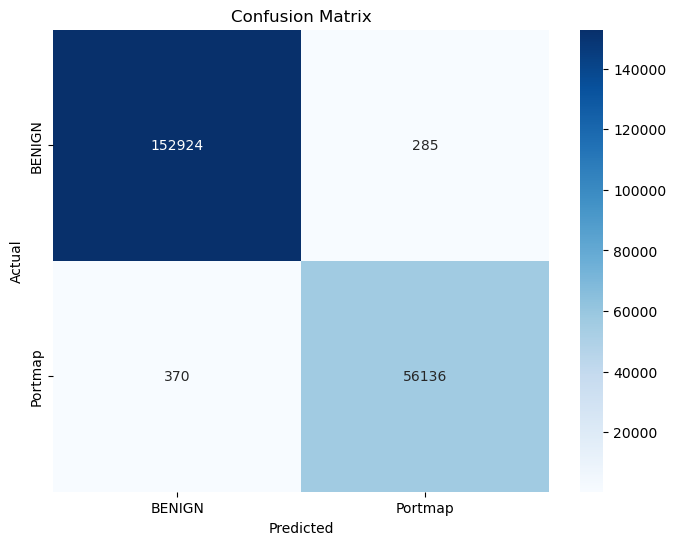

In [118]:
# Visualize the confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['BENIGN', 'Portmap'], yticklabels=['BENIGN', 'Portmap'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


In [120]:
# Generate a classification report
report = classification_report(y_test, y_pred_xgb)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    153209
           1       0.99      0.99      0.99     56506

    accuracy                           1.00    209715
   macro avg       1.00      1.00      1.00    209715
weighted avg       1.00      1.00      1.00    209715



In [122]:
# Calculate ROC AUC score if probabilities are needed
y_pred_proba = xgb_classifier.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC AUC Score: {roc_auc:.2f}")


ROC AUC Score: 1.00


In [124]:
# Risk scoring based on detected anomalies and classification results
df['Risk_Score'] = df.apply(lambda row: row['Anomaly'] * 10 + (1 if row['Label'] == 'Portmap' else 0), axis=1)

In [125]:
# Check for NaN values in the entire DataFrame
print(df.isnull().sum())


Flow ID                          4810
Source IP                        4810
Source Port                      4817
Destination IP                   4810
Destination Port                 4817
Protocol                         4810
Flow Duration                       0
Total Fwd Packets                   0
Total Backward Packets              0
Total Length of Fwd Packets         0
Total Length of Bwd Packets         0
Fwd Packet Length Max               0
Fwd Packet Length Min               0
Fwd Packet Length Mean              0
Fwd Packet Length Std               0
Bwd Packet Length Max               0
Bwd Packet Length Min               0
Bwd Packet Length Mean              0
Bwd Packet Length Std               0
Flow Bytes/s                        0
Flow Packets/s                      0
Flow IAT Mean                       0
Flow IAT Std                        0
Flow IAT Max                        0
Flow IAT Min                        0
Fwd IAT Total                       0
Fwd IAT Mean

In [136]:
print(df['Label'].unique())


['BENIGN' 'Portmap']


In [138]:
# Alerting and Investigation (Example)
def generate_alerts(df, risk_threshold):
    alerts = df[df['Risk_Score'] >= risk_threshold]
    return alerts

alerts = generate_alerts(df, 15)

print("Alerts generated:")
print(alerts[['Source IP', 'Destination IP', 'Risk_Score']])

Alerts generated:
Empty DataFrame
Columns: [Source IP, Destination IP, Risk_Score]
Index: []
